Data downloaded from https://cd.epic.epd.gov.hk/EPICDI/air/station/
on January 12th 2019.

Data is located in subfolder data-files, and split into 4 csv files, each containing
data from one year from one station (Tung Chung and Hong Kong Central).

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math

In [2]:
subfolder = "data-files"
file_names=os.listdir(subfolder)
# load the csvs
frames=[]

for file in file_names:
    if not file.startswith("."):
        complete_path=subfolder + "/" + file
        df=pd.read_csv(complete_path, header=10)
        df['file']=file
        frames.append(df)
# for each dataframe we want to calculate the additional columns
# 24h average of the particulate matter
# 8h average of the ozone concentration
    


In [3]:
new_cols=["FSP_24","RSP_24","O3_8"]
for col in new_cols:
    frames[0][col]=0

# values we want to replace N.A. 
# counts for missing values in one dataset
(frames[0]=="N.A.").sum()

DATE         0
HOUR         0
STATION      0
CO         162
FSP        361
NO2        101
NOX        101
O3         120
RSP        362
SO2        103
file         0
FSP_24       0
RSP_24       0
O3_8         0
dtype: int64

In [4]:
frames[0]=frames[0].replace("N.A.", np.NaN)

# for imputing the missing variables we use a 24h rolling average
columns=["FSP","RSP","CO","NO2","NOX","O3","SO2"]
frames[0][columns].fillna(frames[0][columns].rolling(24,min_periods=1).mean())
# imputation methodology is not the same as the officially used (which is not
# disclosed). This may cause some inaccuracies.
# it is questionable whether we should report missing values at all...

def impute_missing(frames):
    columns=["FSP","RSP","CO","NO2","NOX","O3","SO2"]
    frames2=[]
    for frame in frames:
        frame=frame.replace("N.A.", np.NaN)
        # save the information of invalid data
        frame["nans"]=frame.isnull().any(axis=1)
        # disable the following line if we do not wish to impute missing values
        frame.fillna(method='ffill', inplace=True)
        # in case there is still some missing, back propagation
        frame.fillna(method='bfill', inplace=True)
        frames2.append(frame)
    return frames2

frames=impute_missing(frames)

In [5]:
# calculate moving averages
df_temp=frames[2]

def compute_moving_averages(df):
    min_period_count=2
    df["FSP_24"]=df["FSP"].rolling(24,min_periods=min_period_count).mean()
    df["RSP_24"]=df["RSP"].rolling(24,min_periods=min_period_count).mean()
    df["O3_8"]=df["O3"].rolling(8,min_periods=min_period_count).mean()
    return df

frames2=[]
for frame in frames:
    frames2.append(compute_moving_averages(frame))
frames=frames2

In [6]:
# Lets have a look on the data
frames[0].head()

,DATE,HOUR,STATION,CO,FSP,NO2,NOX,O3,RSP,SO2,file,FSP_24,RSP_24,O3_8,nans
0,1/1/2017,1,CENTRAL,56,23,47,71,61,42,2,hk-air_hourly2017.csv,NaN,NaN,NaN,False
1,1/1/2017,2,CENTRAL,50,17,32,39,69,36,1,hk-air_hourly2017.csv,20.00,39.000000,65.0,False
2,1/1/2017,3,CENTRAL,56,14,36,46,65,31,2,hk-air_hourly2017.csv,18.00,36.333333,65.0,False
3,1/1/2017,4,CENTRAL,46,13,21,27,73,27,1,hk-air_hourly2017.csv,16.75,34.000000,67.0,False
4,1/1/2017,5,CENTRAL,46,6,18,23,70,16,1,hk-air_hourly2017.csv,14.60,30.400000,67.6,False


# Pollutants to Air quality indices
Next challenge is to transform the hourly pollutant level data into either -> AQHI (air quality health index, by environmental protection department of HK)
-> AQI (air quality index, by environmental protection agency of the USA)

## AQI US Calculation
Explanation on how to calculate the US AQI can be found documented in wikipedia
https://en.wikipedia.org/wiki/Air_quality_index#Computing_the_AQI

Since there exists a well documented Python package for calculating the US AQI we resort to that for now. The library is called ```python-aqi```. Source code and documentation can be found [on github](https://github.com/hrbonz/python-aqi).

Installation is done in command line interface with ```pip install python-aqi```, and importing with ```import aqi```.

In [7]:
import aqi

### Terminology
Carbon Monoxide = CO  
Fine Suspended Particulates = FSP = PM25  
Nitrogen Dioxide = NO2  
Nitrogen Oxides = NOX  
Ozone = O3  
Respirable Suspended Particulates = RSP = PM10  
Sulphur Dioxide = SO2  


### AQI components
For computing the AQI in addition to hourly measures we will need  
* 8h average of the Ozone concentration
* 24h average of the PM25 concentration
* 24h average of the PM10 concentration

When reporting current air quality conditions averaging past 24h observations
would not make much sense, the US EPA uses an averaging system called [NowCast]( https://en.wikipedia.org/wiki/NowCast_(air_quality_index%29).

TODO: NowCast computation

Currently we resort to observed values, and calculate the real 24h averages (which are of course not same as the reported momentary predictive AQI values)


### Hong Kong AQHI
AQHI (air quality health index) is a measure designed to signal the expected health
effects of present pollutant concentration.

A study report by a team in CUHK may be found [online](http://www.aqhi.gov.hk/pdf/related_websites/APIreview_report.pdf) and the [general portal in english](http://www.aqhi.gov.hk/en.html) by the HK Environmental Protection Department.

The Hong Kong AQHI is based on the [Canadian counterpart](https://en.wikipedia.org/wiki/Air_Quality_Health_Index_(Canada)), but the model parameters have been recalibrated to localize the model.

The model for computing the AQHI is shown in full [in EPD's faq](http://www.aqhi.gov.hk/en/what-is-aqhi/faqs.html).


In [8]:
# Function for computing the AQHI
def added_risk(beta,concentration):
    '''generic added risk function for computing the added health risk
    of a pollutant concentration'''
    ar=math.expm1(beta*float(concentration))*100.0
    return ar

def aqhi_func(conc, added_risk):
    '''each input represents the 3h moving average
    of the pollutant concentration in question'''
    #constants (regression coefficients)
    pollutants=["NO2","SO2","O3","PM10","PM25"]
    betas=[0.0004462559,0.0001393235,0.0005116328,0.0002821751,0.0002180567]
    ars=list(map(added_risk, betas, conc))
    ar_total=sum(ars[0:2])+max(ars[3:4])
    return ar_total

def aqhi_function2(added_risk):
    '''wrapper function to avoid giving added_risk every time as argument'''
    return lambda conc: aqhi_func(conc,added_risk) 
aqhi_function = aqhi_function2(added_risk)
# aqhi_function same as aqhi_func but with one argument less

In [9]:
conc_test=[115,15,4,65,40]
print(aqhi_function(conc_test))

7.326174439235971


In [10]:
# TODO:
# [x] function to add 3h moving average
# [x] functions to calculate the 24h and 8h moving averages for respective pollutants
# [x] function to handle missing values

In [11]:
def add_3h_moving_averages(frames):
    '''Function to add and calculate 3h moving averages
    of pollutants. 3h averages needed for AQHI computation'''
    columns=["FSP","RSP","CO","NO2","NOX","O3","SO2"]
    addition="_3"
    frames2=[]
    for frame in frames:
        for column in columns:
            frame[column+addition]=frame[column].rolling(3,min_periods=1).mean()
        frames2.append(frame)
    return frames2
frames=add_3h_moving_averages(frames)

In [12]:
# Lets compute the AQHI values
def add_aqhi_to_df(df):
    # order of input variables
    # pollutants=["NO2","SO2","O3","PM10","PM25"]
    column_order=["NO2","SO2","O3","RSP","FSP"]
    column_order_3h=[column + "_3" for column in column_order]
    df["AQHI"]=df[column_order_3h].apply(aqhi_function,axis=1)
    df["AQHI_instant"]=df[column_order].apply(aqhi_function,axis=1)
    return df
temp=add_aqhi_to_df(frames[0])
print("descriptive statistics for the AQHI")
temp["AQHI"].describe()


descriptive statistics for the AQHI


count    8784.000000
mean        4.680934
std         2.433589
min         0.528306
25%         2.905796
50%         4.209872
75%         5.989097
max        17.276088
Name: AQHI, dtype: float64

In [13]:
print("descriptive statistics for the AQHI (instant)")
temp["AQHI_instant"].describe()

descriptive statistics for the AQHI (instant)


count    8784.000000
mean        4.682591
std         2.506636
min         0.495487
25%         2.873070
50%         4.231450
75%         5.999938
max        18.284179
Name: AQHI_instant, dtype: float64

In [14]:
def add_aqhi_to_df_list(frames,add_aqhi_to_df):
    for frame in frames:
        frames2.append(add_aqhi_to_df(frame))
    return frames2

frames=add_aqhi_to_df_list(frames,add_aqhi_to_df)

In [61]:
# Next we need to compute the AQI US and add it to the dataframes.
# For this we use the aqi library

# generate simple functions
def pollutant_to_aqi(pollutant):
    return lambda conc: aqi.to_aqi([(pollutant, conc)])
aqi_pm25=pollutant_to_aqi(aqi.POLLUTANT_PM25)

# List of pollutant symbols from aqi library
# "POLLUTANT_PM25, POLLUTANT_PM10,
#                          POLLUTANT_O3_8H, POLLUTANT_O3_1H,
#                          POLLUTANT_CO_8H, POLLUTANT_SO2_1H,
#                          POLLUTANT_NO2_1H"

pollutant_list=[aqi.POLLUTANT_PM25, aqi.POLLUTANT_PM10,
                          aqi.POLLUTANT_O3_8H, aqi.POLLUTANT_O3_1H,
                          aqi.POLLUTANT_CO_8H, aqi.POLLUTANT_SO2_1H]

if 1==0: # full pollutants list
    pollutants_dict={aqi.POLLUTANT_PM25: "FSP_24", aqi.POLLUTANT_PM10: 'RSP_24',
    aqi.POLLUTANT_O3_8H : 'O3_8', aqi.POLLUTANT_O3_1H: 'O3',
    aqi.POLLUTANT_CO_8H: 'CO', aqi.POLLUTANT_SO2_1H : 'SO2',
    aqi.POLLUTANT_NO2_1H : 'NO2'}        
else: #partial pollutants list
    pollutants_dict={aqi.POLLUTANT_PM25: "FSP_24", aqi.POLLUTANT_PM10: 'RSP_24',
                     aqi.POLLUTANT_SO2_1H : 'SO2',
    aqi.POLLUTANT_NO2_1H : 'NO2'}     
    
frames[0]['FSP'].apply(aqi_pm25).head()

0    74
1    61
2    55
3    53
4    25
Name: FSP, dtype: object

In [110]:
# generate functions
# def pollutant_to_aqi(pollutant):
#    return lambda conc: aqi.to_aqi([(pollutant, conc)])
def compute_aqi_to_df(frame,pollutants_dict,pollutant_to_aqi):
    frame.fillna(method='bfill', inplace=True)
    aqi_names=pollutants_dict.keys()
    aqi_names=[name +"_aqi" for name in list(aqi_names)]
    for aqi_name, data_name in pollutants_dict.items():
        aqi_temp_func=pollutant_to_aqi(aqi_name)
        frame[aqi_name+"_aqi"]=frame[data_name].apply(aqi_temp_func)
    frame["aqi_max"]=frame[aqi_names].apply(max,axis=1)
    return frame

compute_aqi_to_df_simple = lambda frame: compute_aqi_to_df(frame,pollutants_dict,pollutant_to_aqi)

def aqi_to_all_dfs(frames):
    for frame in frames:
        frame=compute_aqi_to_df_simple(frame)
    return frames
frames=aqi_to_all_dfs(frames)

        

In [152]:
freq, bins = np.histogram(np.array(frames[2]["aqi_max"],dtype=np.float64), bins=100)
vals=(bins[:-1] + bins[1:]) 


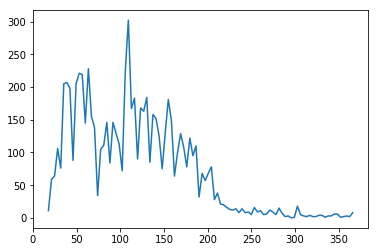

In [153]:
plt.plot(vals,freq)
plt.show()

In [262]:
# List of plots to do:
# [ ] scatter of US AQI and HK AQHI
# [ ] time series of both with separate vert axis
# [ ] histograms of both 
# [ ] functions to do these plots for all datasets
# [ ]
# [ ]
# [ ]
# [ ]
# [ ]

# quality ranges
d={'aqi_us_min': [0, 51, 151, 201, 301],
    'aqi_us_max': [50, 100, 200, 300, 9999],
    'aqhi_min': [1, 4, 7, 8, 11],
    'aqhi_max': [3, 6, 7, 10, 50]}
quality_ranges = pd.DataFrame(data=d)
quality_ranges

,aqi_us_min,aqi_us_max,aqhi_min,aqhi_max
0,0,50,1,3
1,51,100,4,6
2,151,200,7,7
3,201,300,8,10
4,301,9999,11,50


### Air quality index ranges

In the table below a mapping of the qualitative scales of air quality indices in use in Hong Kong / US.

|Description| <td colspan=1> AQI US| <td colspan=1> AQHI HK|
|---        | -  --|--            -| -            -- | --- |
|           | min | max | min | max |
|   Good    | 0   | 50  | 1   | 3   |
|   Moderate    | 50   | 100  | 4   | 6   |
|   Unhealthy    | 150   | 200  | 7   | 7   |
|   Very Unhealthy/Very High    | 200   | 300  | 8   | 10   |
|   Hazardous/Serious    | 300   | na | 11    | na  |

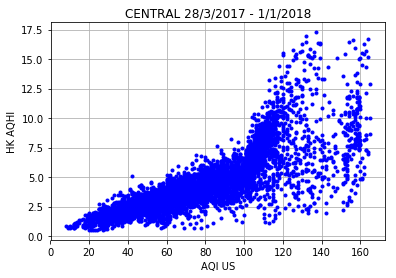

8

In [266]:
# Scatter plot
def air_quality_scatter(frame,days):
    start,end=-24*days,-1
    hour=frame["HOUR"][start:end]
    date=frame["DATE"][start:end]
#    plt.plot(date,frame["AQHI"][start:end],'-b')   
    plt.plot(frame["aqi_max"][start:end],frame["AQHI"][start:end],'.b')
    plt.grid()
    print()
    title=frame["STATION"][0]+" "+date.iloc[0]+" - "+date.iloc[-1]
    plt.title(title)
    plt.xlabel("AQI US")
    plt.ylabel("HK AQHI")
    plt.show()
    return None

days=7*40
if 1==0:
    for frame in frames:
        air_quality_scatter(frame,days)

air_quality_scatter(frames[0],days)
len(frames)


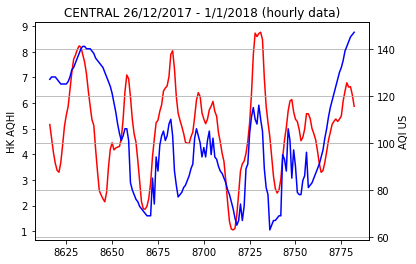

In [248]:
# time series plot
def air_quality_timeseries(frame,days):
    start,end=-24*days,-1
    hour=frame["HOUR"][start:end]
    date=frame["DATE"][start:end]
    
    fig, ax1 = plt.subplots() 
    ax1.plot(frame["AQHI"][start:end],'-r')  
    ax2 = ax1.twinx()  
    ax2.plot(frame["aqi_max"][start:end],'-b') 
    plt.grid()
    print()
    title=frame["STATION"][0]+" "+date.iloc[0]+" - "+date.iloc[-1]+" (hourly data)"
    plt.title(title)
    ax2.set_ylabel("AQI US")
    ax1.set_ylabel("HK AQHI")
    plt.show()
    return None

days=7*1
air_quality_timeseries(frames[0],days)

In [ ]:
# distribution plots

In [156]:
frames[0].keys()

Index(['DATE', 'HOUR', 'STATION', 'CO', 'FSP', 'NO2', 'NOX', 'O3', 'RSP',
       'SO2', 'file', 'FSP_24', 'RSP_24', 'O3_8', 'nans', 'FSP_3', 'RSP_3',
       'CO_3', 'NO2_3', 'NOX_3', 'O3_3', 'SO2_3', 'AQHI', 'AQHI_instant',
       'pm25+aqi', 'pm10+aqi', 'so2_1h+aqi', 'no2_1h+aqi', 'pm25_aqi',
       'pm10_aqi', 'so2_1h_aqi', 'no2_1h_aqi', 'aqi_max'],
      dtype='object')

In [90]:
# testing the aqi library's to_aqi function - seems to work
aqi.to_aqi([
    (aqi.POLLUTANT_PM25, df['FSP'].iloc[1]),
    (aqi.POLLUTANT_PM10, '24'),
    (aqi.POLLUTANT_O3_8H, '0.087')
])

Decimal('139')

In [305]:
aqi.POLLUTANT_PM25

'pm25'

### Data for comparison

For comparison and validation we need to download the hourly AQHI data, and respective US AQI data to run the comparison

In [160]:
# Lets concatenate dataframes
dfa=pd.concat(frames)

# References

1. [Development and Application of a Next Generation
Air Sensor Network for the Hong Kong Marathon
2015 Air Quality Monitoring](https://pdfs.semanticscholar.org/76b5/d17b3d917cf5b9a16a6afd806d1c8f3ba7bc.pdf)
2. [How is the hourly AQHI calculated?](http://www.aqhi.gov.hk/en/what-is-aqhi/faqs.html#e_02)
3. [Computing the AQI](https://en.wikipedia.org/wiki/Air_quality_index#Computing_the_AQI)
4. [NowCast (air quality index)](https://en.wikipedia.org/wiki/NowCast_(air_quality_index%29)
5. [Inquire and Download Air Quality Monitoring Data](https://cd.epic.epd.gov.hk/EPICDI/air/station/)
6. [A library to convert between AQI value and pollutant concentration (µg/m³ or ppm)](https://github.com/hrbonz/python-aqi/blob/master/aqi/algos/epa.py)
7. [Past AQHI Record for Download
](http://www.aqhi.gov.hk/en/aqhi/statistics-of-aqhi/past-aqhi-records.html)